# **Model Evaluation**

## Objectives

* Evaluate the performance of the optimized Gradient Boosting and XGBRegressor models.
* Analyze feature importance to understand which variables have the most influence on house prices.
* Ensure that the chosen model meets the business requirement (R2 ≥ 0.75)

## Inputs

* The prepared dataset (`HousePricesFeatures.csv`)
* Libraries for machine learning and data handling, including:
  - **pandas** for data manipulation.
  - **sklearn** for machine learning and model training.
  - **matplotlib** and **seaborn** for visualizations.
  - **joblib** for saving and loading models.


## Outputs

* The optimized XGBRegressor model is saved as: jupyter_notebooks/outputs/best_model/best_xgboost_model.pkl.
* Visualization of feature importance.
* Model evaluation metrics (MSE, R2).
* Conclusions regarding the model's performance and usability.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [14]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [15]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [16]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBRegressor

# Load data

In [16]:
df = pd.read_csv("outputs/datasets/collection/HousePricesFeaturesSelected.csv")
df.head()

,OverallQual,GrLivArea,GarageArea,KitchenQual_Ex,KitchenQual_TA,SalePrice
0,0.651479,0.370333,0.351000,0,0,208500.0
1,-0.071836,-0.482512,-0.060731,0,1,181500.0
2,0.651479,0.515013,0.631726,0,0,223500.0
3,0.651479,0.383659,0.790804,0,0,140000.0
4,1.374795,1.299326,1.698485,0,0,250000.0


In [8]:
# Define features and target variable
X = df.drop('SalePrice', axis=1)
y = np.log1p(df['SalePrice'])  # Log-transform the target variable

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### **Gradient Boosting Regressor optimization**

In [10]:
pipeline = Pipeline([
    ('model', GradientBoostingRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Perform randomized search for hyperparameters
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from random search: {random_search.best_params_}")

# Evaluate the optimized model
optimized_model = random_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Inverse log-transform predictions and target
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_optimized)

# Calculate metrics
mse_optimized = mean_squared_error(y_test_original, y_pred_original)
r2_optimized = r2_score(y_test_original, y_pred_original)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   7.8s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   7.9s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   8.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   8.1s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   8.3s
[CV] END model__max_depth=30, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300; total time=   8.2s
[CV] END model__max_depth=None, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   8.5s
[CV] END model__max_dep

##### **XGBRegressor optimization**

In [12]:
pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42))  # Model to train
])

# Define the parameters for randomized search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__learning_rate': [0.01, 0.05, 0.1],  # Typical learning rates for XGBoost
    'model__subsample': [0.8, 1.0],  # Subsample ratio
    'model__colsample_bytree': [0.8, 1.0],  # Column subsample ratio
}


# Perform randomized search for hyperparameters
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found and evaluate the model
print(f"Best hyperparameters from random search: {random_search.best_params_}")

# Evaluate the optimized model
optimized_model = random_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)

# Inverse log-transform predictions and target
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_optimized)

# Calculate metrics
mse_optimized = mean_squared_error(y_test_original, y_pred_original)
r2_optimized = r2_score(y_test_original, y_pred_original)

print(f"Optimized MSE: {mse_optimized}")
print(f"Optimized R2 Score: {r2_optimized}")


xgb_model = optimized_model.named_steps['model']


print(f"Saving the best model: {type(xgb_model)}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   1.4s
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=None, model__n_estimators=100, model__subsample=1.0; total time=   1.3s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   4.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   4.7s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=30, model__n_estimators=100, model__subsample=1.0; total time=   5.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=

##### **Conclusion:**
Both models performed well, but **XGBRegressor** slightly outperforms **Gradient Boosting Regressor** with a higher R2 Score of **0.89** compared to **0.88** for **Gradient Boosting**. The **Mean Absolute Error** for both models is relatively similar, but **XGBRegressor** has a lower error.

Given this, **XGBRegressor** is chosen as the final model for predicting house prices due to its better performance after optimization.

In [15]:
joblib.dump(xgb_model, 'outputs/best_model/best_xgboost_model.pkl')
print("Model saved successfully.")

Model saved successfully.


___

##### **Calculating Feature Importance**

In [17]:
# Calculate permutation importance
result = permutation_importance(optimized_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame to store the results
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Check the DataFrame
print(importance_df.head())

       Feature  Importance
1    GrLivArea    0.286039
0  OverallQual    0.248468
5   BsmtFinSF1    0.051520
2   GarageArea    0.043156
8     2ndFlrSF    0.016826


             Feature  Importance
1          GrLivArea    0.286039
0        OverallQual    0.248468
5         BsmtFinSF1    0.051520
2         GarageArea    0.043156
8           2ndFlrSF    0.016826
12    KitchenQual_TA    0.014653
7     KitchenQual_Gd    0.008118
11  GarageFinish_Unf    0.007689
3     KitchenQual_Ex    0.006376
10   BsmtExposure_No    0.001760
4   BsmtFinType1_GLQ    0.000525
9    BsmtExposure_Gd    0.000471
6   GarageFinish_Fin    0.000423


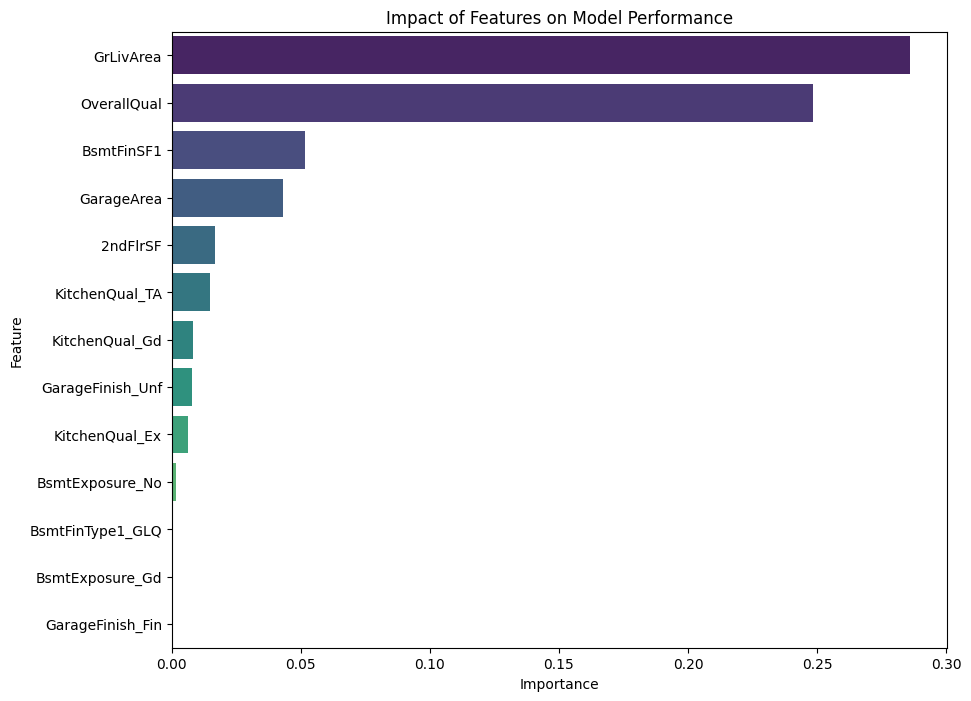

In [18]:
# Visualize permutation importance
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", orient="h", hue='Feature')
plt.title("Impact of Features on Model Performance")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Set the x-axis to start at 0
plt.xlim(left=0)

# Display the importance dataframe
print(importance_df)
plt.show()

### **Feature Importance Analysis**
- **OverallQual** is the most important feature and has the biggest impact on the model’s performance. This means that the overall quality of a house is a key factor in determining its price. For real estate developers or sellers, this suggests that improving the house's quality can lead to higher prices.

- **GrLivArea (living area)** and **BsmtFinSF1 (finished basement area)** are also important for pricing. Larger living spaces and more usable basement areas usually result in higher house prices. This is useful for builders and sellers to know that increasing house size or usable space can increase value.

- Features like **GarageArea** and **2ndFlrSF (second floor area)** have smaller, but still important, effects on the model’s predictions. While these features are not as critical as the others, they still influence pricing, showing that buyers may care about having more garage space or a second floor, which could increase the house price if there is one..
